# Detecting Drift in Text + Structured Data

Here, we load the civilcomments dataset; a dataset of comments from the Civil Comments platform and some annotations (i.e., structured data). The dataset is available on [Kaggle](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data). We use the prepackaged loaders in the WILDS library to load the dataset.

In [53]:
!pip install wilds --quiet
!pip install matplotlib --quiet

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [2]:
%load_ext autoreload
%autoreload 2

In [54]:
from gate import summarize, detect_drift
from wilds import get_dataset

import numpy as np
import os
import pandas as pd

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [4]:
raw_dataset = get_dataset(
    dataset="civilcomments", download=True, root_dir="data"
)
df = pd.read_csv(
    os.path.join(
        "data", "civilcomments_v1.0", "all_data_with_identities.csv"
    )
)
# df["created_date"] = pd.to_datetime(df["created_date"], format='mixed')

# Sample 10,000 rows from the dataset
df = df.sample(n=20000, random_state=42).reset_index(drop=True)

To create partitions, we can look at the toxicity levels of the comments.

<Axes: >

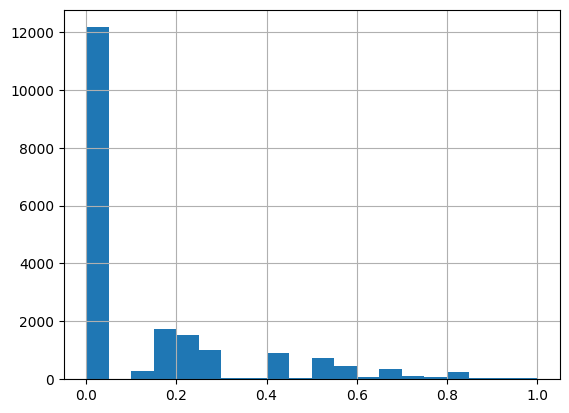

In [5]:
df["toxicity"].hist(bins=20)

We'll create 10 partitions; one with low toxicity levels, one with high toxicity levels, and the other 8 with a random mix of toxicity levels.

In [6]:
def assign_partition(toxicity):
    if toxicity < 0.1:
        return "9_low"
    elif toxicity > 0.9:
        return "9_high"
    else:
        i = np.random.choice([1, 2, 3, 4, 5, 6, 7, 8])
        return f"{i}_medium"

df["partition"] = df["toxicity"].apply(assign_partition)
df.head()

,Unnamed: 0,id,comment_text,split,created_date,publication_id,parent_id,article_id,rating,funny,...,disability_any,identity_any,num_identities,more_than_one_identity,na_gender,na_orientation,na_religion,na_race,na_disability,partition
0,315698,5041802,"Thank you Stephanie, great post. You should be...",train,2017-03-23 02:09:07.887924+00,55,NaN,320734,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
1,205291,5924876,"Poor, poor us! We're so abused! Give it a brea...",train,2017-09-09 14:08:31.131728+00,54,5923381.0,375645,rejected,0,...,0,1,1.0,False,0,1,1,1,1,6_medium
2,98697,5926727,"Yeah, as we've gotten so used to with the Rock...",train,2017-09-09 20:35:55.150162+00,102,5924578.0,375714,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
3,42002,5785459,"If your actions thereby assist Sears' failure,...",test,2017-08-17 04:15:42.186750+00,54,5785299.0,367422,approved,0,...,0,0,0.0,False,1,1,1,1,1,9_low
4,385519,5240478,"It is indeed a balancing act, but by supportin...",train,2017-05-10 22:34:47.727569+00,53,5238832.0,333501,approved,0,...,0,1,2.0,True,0,1,0,1,1,3_medium


## Create Embeddings

For the `comment_text` column, we create embeddings using the huggingface `sentence-transformers` library.

In [7]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')
comments = df["comment_text"].tolist()
embeddings = model.encode(comments, show_progress_bar=True)

Batches: 100%|██████████| 625/625 [02:22<00:00,  4.39it/s]


In [8]:
df["comment_embedding"] = [e for e in embeddings]

## Create Partition Summaries

We use the `summarize` function to create partition summaries for each partition. We use the `comment_text` column as the embedding key, and the `comment_embedding` column as embedding value. We also pass in other columns that we want to compute statistics for.

In [23]:
columns = [
    "rating",
    "toxicity",
    "funny",
    "wow",
    "sad",
    "likes",
    "disagree",
    "severe_toxicity",
    "obscene",
    "sexual_explicit",
    "identity_attack",
    "insult",
    "threat",
    "male",
    "female",
    "transgender",
    "other_gender",
    "heterosexual",
    "homosexual_gay_or_lesbian",
    "bisexual",
    "other_sexual_orientation",
    "christian",
    "jewish",
    "muslim",
    "hindu",
    "buddhist",
    "atheist",
    "other_religion",
    "black",
    "white",
    "asian",
    "latino",
    "other_race_or_ethnicity",
    "physical_disability",
    "intellectual_or_learning_disability",
    "psychiatric_or_mental_illness",
    "other_disability",
    "identity_annotator_count",
    "toxicity_annotator_count",
    "LGBTQ",
    "other_religions",
    "asian_latino_etc",
    "disability_any",
    "identity_any",
    "num_identities",
    "more_than_one_identity",
    "na_gender",
    "na_orientation",
    "na_religion",
    "na_race",
    "na_disability",
]
partition_key = "partition"
embedding_key = "comment_text"
embedding_value = "comment_embedding"

In [24]:
summaries = summarize(df, columns, partition_key=partition_key, embedding_column_map={embedding_key: embedding_value})
print(f"Computed summaries for {len(summaries)} partitions.")

Computed summaries for 10 partitions.


We can print out the summary of the first partition:

In [25]:
print(summaries[0])

Regular summary:
   partition                               column  coverage       mean  num_unique_values  occurrence_ratio   p50        p95
0   1_medium                                LGBTQ       1.0   0.074297                2.0          0.925703   0.0   1.000000
1   1_medium                                asian       1.0   0.012334                NaN               NaN   0.0   0.000000
2   1_medium                     asian_latino_etc       1.0   0.019076                2.0          0.980924   0.0   0.000000
3   1_medium                              atheist       1.0   0.003130                NaN               NaN   0.0   0.000000
4   1_medium                             bisexual       1.0   0.001924                NaN               NaN   0.0   0.000000
5   1_medium                                black       1.0   0.062622                NaN               NaN   0.0   0.800000
6   1_medium                             buddhist       1.0   0.001975                NaN               NaN 

## Compute Drift

For each partition after the first 5 partitions, we compute the drift between the partition and historical partitions.

In [26]:
partition_names = [s.partition for s in summaries]

In [27]:
drifted_partitions = {}

for i in range(len(summaries)-2, len(summaries)):
    print(f"Checking partition {partition_names[i]}...")
    drift_results = detect_drift(summaries[i], summaries[:i])    
    if drift_results.score_percentile > 0.85: # We use this instead of is_drifted since is_drifted's threshold is 95th percentile, and we want to be less strict since we only have 10 partitions
        print(f"Drift detected in partition {partition_names[i]}!")
        drifted_partitions[partition_names[i]] = drift_results

Checking partition 9_high...
Drift detected in partition 9_high!
Checking partition 9_low...
Drift detected in partition 9_low!


## Inspect Drift Results

For the high and low toxicity partitions, we can print out the top drifted columns and drift score.

Looks like the top drifted columns for high toxicity imply that there were fewer male-annotated records (the z score is less than 0)! And the top drifted columns for low toxicity imply that there were fewer muslim-annotated records.

In [34]:
def get_summary(partition_name):
    for summary in summaries:
        if summary.partition == partition_name:
            return summary
    return None


partition_name = list(drifted_partitions.keys())[0]
print(partition_name)
drift_results_high = drifted_partitions[partition_name]
print(drift_results_high)

9_high
Drift score: 5.3369 (100.00% percentile)
Top drifted columns:
                         statistic   z-score  cluster  abs(z-score-cluster)
column                                                                     
male                           p95 -2.666667      0.0              1.262680
severe_toxicity                p95  2.666667      0.0              1.262680
toxicity_annotator_count       p50 -2.666667      0.0              0.455285
sexual_explicit                p95 -2.666667      0.0              1.262680
white                          p95 -2.666667      0.0              1.262680
insult                         p50  2.666667      0.0              0.455285
more_than_one_identity         p95 -2.666667      0.0              1.262680
LGBTQ                          p95 -2.666667      0.0              1.262680
num_identities                 p50 -2.666667      0.0              0.455285
identity_any                   p50 -2.666667      0.0              0.455285


In [35]:
partition_name = list(drifted_partitions.keys())[1]
print(partition_name)
drift_results_low = drifted_partitions[partition_name]
print(drift_results_low)

9_low
Drift score: 5.4092 (100.00% percentile)
Top drifted columns:
                                       statistic   z-score  cluster   
column                                                                
muslim                                       p95 -2.797171      2.0  \
threat                                       p95 -2.776643      0.0   
toxicity_annotator_count        occurrence_ratio  2.735894      0.0   
toxicity                                     p95 -2.708302      0.0   
funny                          num_unique_values  2.676653      0.0   
sexual_explicit                             mean -2.649395      1.0   
identity_attack                             mean -2.640295      0.0   
insult                                       p95 -2.627020      0.0   
severe_toxicity                              p95 -2.546198      0.0   
psychiatric_or_mental_illness               mean -2.448941      0.0   

                               abs(z-score-cluster)  
column                   

In [40]:
print(f"There were {len(drift_results_high.clustering)} clusters of columns identified in the high toxicity partition and {len(drift_results_low.clustering)} clusters of columns in the low toxicity partition.")

There were 6 clusters of columns identified in the high toxicity partition and 7 clusters of columns in the low toxicity partition.


### Look at Drifted Embeddings for High Toxicity Partition

In the drifted partition, we can identify the cluster of embeddings that diverged most from its values in historical partitions.

`drifted_examples` represents the examples in the drifted partition. `corresponding_examples` represents the examples in the historical partitions.

In [69]:
result = drift_results_high.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [70]:
drifted_examples[embedding_key].to_list()

['Part 1......................The income equality and social justice promised by globalists is the big lie of the 21st century that is duping the useful idiots in the Western world. Globalism is not new - it was described unapologetically in chilling detail by Lord Bertrand Russell in his 1952 book The Impact of Science on Society. Far from providing income equality and social justice the one-world government of the New World Order (NWO) is a binary socio-political system of masters and slaves.   CONT......',
 'Lord, what a tedious, tiresome, transparently deceptive and misleading troll you are.  Are you so delusional that you cannot see by the reactions of other posters that nobody is buying your repetitive and specious spins?  Obviously, Cassie (or whomever you are) your only recourse here is to go on the offensive and attack the reporters and the opposition with blatant lies and misleading out of context drive by smears.  You are certainly succeeding in being offensive, very offensi

In [71]:
corresponding_examples[embedding_key].to_list()

['Now that muslim radical families have a beachhead handed to them here by that stupid little boy. \nIn a decade your daughters will serve sharia warlords in every big city in Canada. Your sons will be cut down like dogs if they don"t convert to Muslim\n.\nThey are having 5-10 kids in each family to overwhelm us.',
 "I've heard that Iranian commandos disguised in sombreros are massing on the border, just awaiting Obama's signal to invade and subject us all to fundamentalist Islam.  LGBTQs are secretly getting ready to blow up fundamentalist Christian churches at the moment of the Iranian attack, to deprive our people of desperately needed moral guidance.  Liberal Hollywood conspirators are planning to release a blockbuster movie in which Captain America wipes his ass with the American flag and joins ISIS.\n\nOur way of life is in mortal danger, people.  Who alone can save us?",
 'Trump and his alt-right advisors will continue to sink us deeper into the Middle East quagmire. They see it

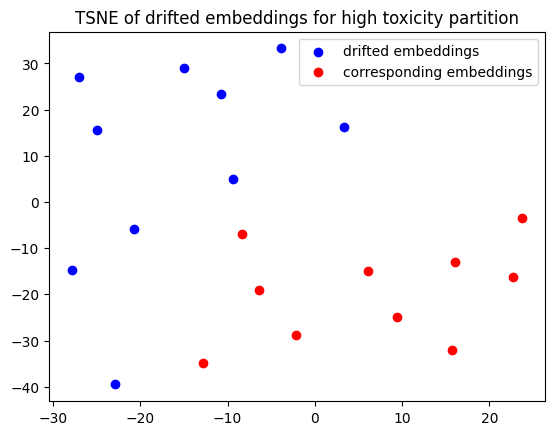

In [72]:
# T-sne for examples

drifted_embeddings = np.vstack(drifted_examples[embedding_value].values)
correspending_embeddings = np.vstack(corresponding_examples[embedding_value].values)

# Concatenate the two arrays vertically
X = np.vstack([drifted_embeddings, correspending_embeddings])

# Compute t-SNE on the concatenated data
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X)

# Separate the t-SNE results for X1 and X2
X1_tsne = X_tsne[:10, :]
X2_tsne = X_tsne[10:, :]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(X1_tsne[:, 0], X1_tsne[:, 1], color='blue', label='drifted embeddings')
ax.scatter(X2_tsne[:, 0], X2_tsne[:, 1], color='red', label='corresponding embeddings')
ax.legend()
plt.title("TSNE of drifted embeddings for high toxicity partition")
plt.show()

We can do the same thing from the low toxicity partition.

In [64]:
result = drift_results_low.drifted_examples("comment_text")
drifted_examples = result["drifted_examples"]
corresponding_examples = result["corresponding_examples"]

In [65]:
drifted_examples[embedding_key].to_list()

['"And why did he affect some kind of accent when he made the statement in Pakistan?"\n\nYou noticed that, too? I wasn\'t sure whether I was imagining it because his current accent is right out of Letterkenny.  But the first time that I heard him, he spoke with an Arabic accent.',
 "Given the purpose of the FBI, aren't they always looking to see if crimes were committed?\n\nAnd hacking into someone's computer is a crime.",
 'May I remind all of you what KA Hall said at the beginning of last year when that Darth Vader lady Berg came in as replacement for Robyn. He said "...there\'s already a huge difference.....it is so much better already...." He threw Robyn under the bus, there is no way he should be on the staff.',
 'As Pr "partial travel ban of nationals from six mostly Muslim countries."\nThere they go again.\nIt was a list of terrorist hotspots started in 1979.\nCurrently Cuba and NK are off the list.\nIt looks like NK will go back on.\nWhat coincidental category will they come up

In [66]:
corresponding_examples[embedding_key].to_list()

['"It\'s hypocrisy to call yourself a Christian and chase away a refugee or someone seeking help," the pope has said. \n\nPeople who put their hatred for people who look different ahead of the Gospel have no business calling themselves Christian.',
 '"What are we American Catholics to do?"\n\n52% of Catholics voted for Trump. I cannot remember any Pope speaking specifically against someone running for POTUS. He couldn\'t have been clearer with his thoughts about Trump and his wall building. The Bishops could have backed Francis but remained silent. \n\nThe first thing American Catholics need to do is get their own house in order and demand leaders worthy of their position.',
 "I agree that both are childish ... but I think the usage with reference to the pope predates the usage with reference to the president; but I'm no expert ....",
 "Oh really. So I can't respond to your comment to Layla? It is you that needs to get a grip, hypocrite with no substance.\n\n1. The Catholic church feed

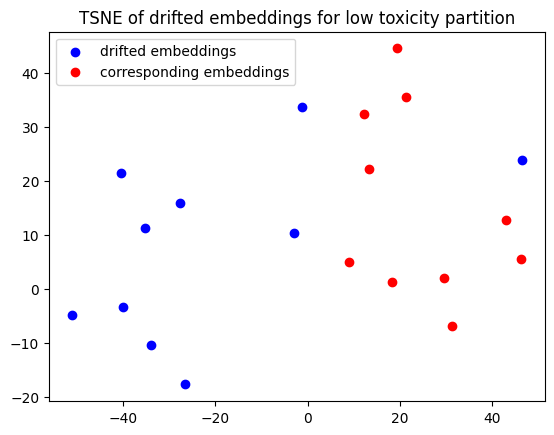

In [68]:
# T-sne for examples

drifted_embeddings = np.vstack(drifted_examples[embedding_value].values)
correspending_embeddings = np.vstack(corresponding_examples[embedding_value].values)

# Concatenate the two arrays vertically
X = np.vstack([drifted_embeddings, correspending_embeddings])

# Compute t-SNE on the concatenated data
tsne = TSNE(n_components=2, perplexity=5, random_state=42)
X_tsne = tsne.fit_transform(X)

# Separate the t-SNE results for X1 and X2
X1_tsne = X_tsne[:10, :]
X2_tsne = X_tsne[10:, :]

# Plot the results
fig, ax = plt.subplots()
ax.scatter(X1_tsne[:, 0], X1_tsne[:, 1], color='blue', label='drifted embeddings')
ax.scatter(X2_tsne[:, 0], X2_tsne[:, 1], color='red', label='corresponding embeddings')
ax.legend()
plt.title("TSNE of drifted embeddings for low toxicity partition")
plt.show()